In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchdiffeq as tde
from functools import singledispatch
from tqdm import tqdm
from terrarium.models.glv import GLV
from terrarium.utils.nets import MLP, OPTIMS
from terrarium.utils.plots import grab_plot, VideoWriter
from terrarium.utils.sugar import attrmethod, buildmethod

100%|██████████| 599/599 [00:00<00:00, 44426.16it/s]


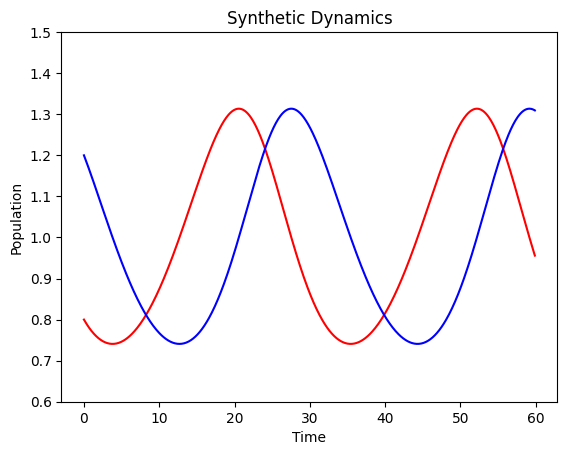

In [2]:
def glv(x, growth_rates, interactions):
    dx = x*(growth_rates + (interactions@x))

    return dx

def k(x, model=glv, dt=.1, *args, **kwargs):
    k1 = model(x, *args, **kwargs)
    k2 = model(x + k1*dt/2, *args, **kwargs)
    k3 = model(x + k2*dt/2, *args, **kwargs)
    k4 = model(x + k3*dt, *args, **kwargs)

    return k1, k2, k3, k4

@singledispatch
def rk_int(x0, model=glv, dt=.1, n_steps=300, *args, **kwargs):
    (X := np.zeros((n_steps, len(x))))[0] = x0

    for i in tqdm(range(1, n_steps)):
        k1, k2, k3, k4 = k(x := X[i - 1], model, dt, *args, **kwargs)
        X[i] = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

@rk_int.register(torch.Tensor)
def _(x0, model=glv, dt=.1, n_steps=300, *args, **kwargs):
    (X := torch.zeros(n_steps, len(x0)))[0] = x0

    for i in tqdm(range(1, n_steps)):
        k1, k2, k3, k4 = k(x := X[i - 1], model, dt, *args, **kwargs)
        X[i] = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

dt, n_steps = .1, 600
# x0 = torch.tensor((.44249296, 4.6280594))
x0 = torch.tensor((.8, 1.2))
growth_rates = torch.tensor((.2, -.2))
interactions = torch.tensor(((0., -.2), (.2, 0.)))
# growth_rates = torch.tensor((.9, -.6))
# interactions = torch.tensor(((0., -.8), (.5, 0.)))
steps = torch.arange(n_steps)

X = rk_int(x0, glv, dt, n_steps, growth_rates, interactions)
plt.plot(steps*dt, X[:, 0], c='red')
plt.plot(steps*dt, X[:, 1], c='blue')
plt.title('Synthetic Dynamics')
plt.xlabel('Time')
plt.ylabel('Population')
plt.ylim(.6, 1.5)
plt.show()

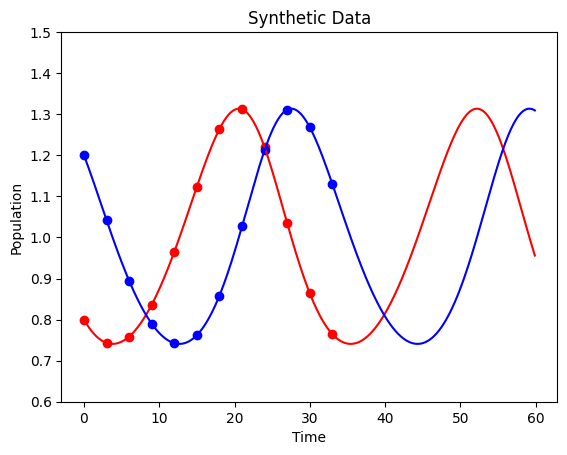

In [3]:
data = X[idx := torch.arange(0, 350, 30)]
plt.plot(steps*dt, X[:, 0], c='red')
plt.plot(steps*dt, X[:, 1], c='blue')
plt.scatter(idx*dt, data[:, 0], c='red')
plt.scatter(idx*dt, data[:, 1], c='blue')
plt.title('Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Population')
plt.ylim(.6, 1.5)
plt.show()

100%|██████████| 2500/2500 [00:15<00:00, 161.40it/s]


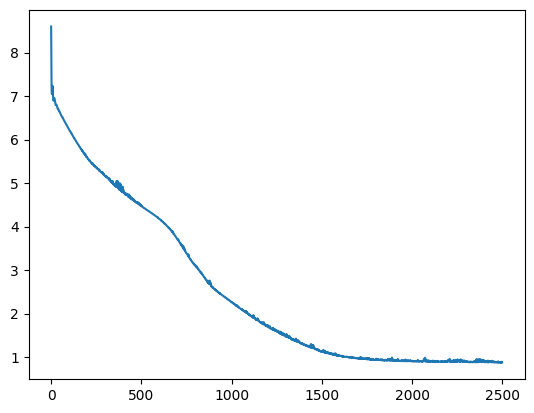

In [5]:
Y = torch.cat((idx[:, None], data), -1)
model = GLV()
model.fit(Y, x0)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

100%|██████████| 599/599 [00:00<00:00, 81089.25it/s]


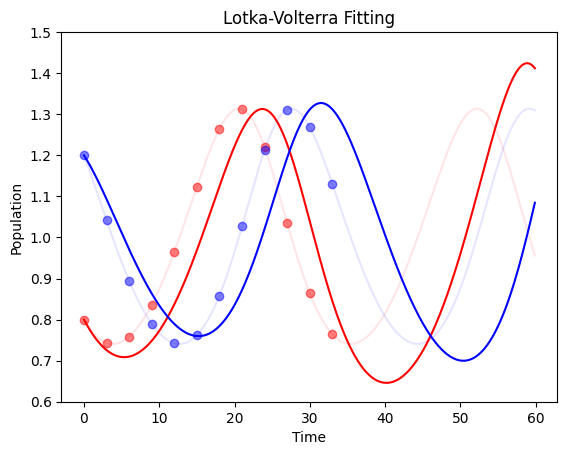

In [6]:
(X_ := torch.zeros((600, 2)))[0] = x0
steps_, dt_ = torch.arange(len(X_)), .1

for i in tqdm(range(1, len(X_))):
    X_[i] = model(X_[i - 1])

plt.plot(steps*dt, X[:, 0], c='red', alpha=.1)
plt.plot(steps*dt, X[:, 1], c='blue', alpha=.1)
plt.scatter(idx*dt, data[:, 0], c='red', alpha=.5)
plt.scatter(idx*dt, data[:, 1], c='blue', alpha=.5)
plt.plot(steps_*dt_, X_[:, 0].detach(), c='red')
plt.plot(steps_*dt_, X_[:, 1].detach(), c='blue')
plt.title('Lotka-Volterra Fitting')
plt.xlabel('Time')
plt.ylabel('Population')
plt.ylim(.6, 1.5)
plt.show()

In [4]:
class GLV(nn.Module):
    @attrmethod
    def __init__(self, optim='adam', *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.loss_log_ = []
        self.param_log_ = []

    def _build(self, x0, learning_rate=1e-3):
        self.r_ = nn.Parameter(torch.zeros(c := len(x0), requires_grad=True))
        self.A_ = nn.Parameter(torch.zeros(c, c, requires_grad=True))
        self.param_log_.append([self.r_.clone().detach(), self.A_.clone().detach()])
        self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

        return self

    def step(self, loss):
        loss.backward()
        self._optim.step()
        self._optim.zero_grad()
        self.loss_log_.append(loss.item())
        self.param_log_.append([self.r_.clone().detach(), self.A_.clone().detach()])

        return self

    def model(self, x, r=None, A=None):
        r is None and (r := self.r_)
        A is None and (A := self.A_)
        dx = x*(r + A@x)

        return dx

    def forward(self, x, y=None, dt=.1, r=None, A=None):
        x_ = x + self.model(x, r, A)*dt

        if y is not None:
            loss = (d := x_ - y).norm(1) + d.norm(2)
            
            return x_, loss
        return x_

    @buildmethod
    def fit(self, Y, x0, dt=.1, n_epochs=2500, n_steps=350, learning_rate=1e-3, verbosity=1):
        for j in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            x, idx, loss = x0.clone(), -1, 0

            for i in range(n_steps):
                if i in Y[1:, 0]:
                    x, l = self(x, Y[idx := idx + 1, 1:])
                    loss += l
                else:
                    x = self(x)

            self.step(loss)

        return self

100%|██████████| 2500/2500 [00:15<00:00, 160.97it/s]


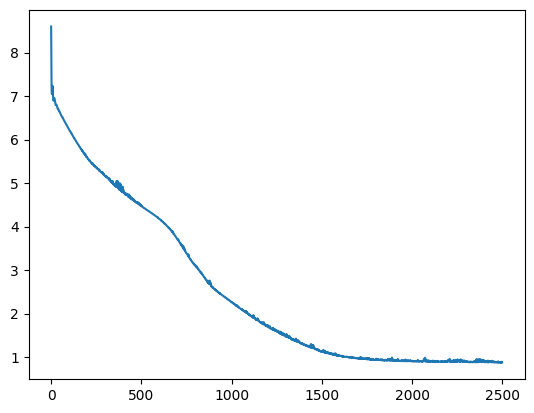

In [5]:
Y = torch.cat((idx[:, None], data), -1)
model = GLV()
model.fit(Y, x0)
plt.plot(range(len(model.loss_log_)), model.loss_log_)
plt.show()

100%|██████████| 599/599 [00:00<00:00, 100403.15it/s]


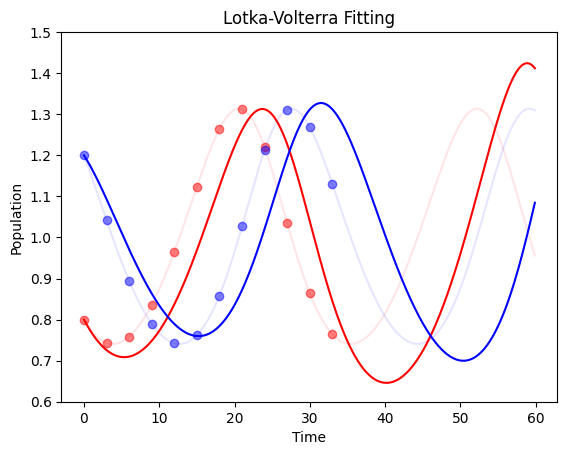

In [6]:
(X_ := torch.zeros((600, 2)))[0] = x0
steps_, dt_ = torch.arange(len(X_)), .1

for i in tqdm(range(1, len(X_))):
    X_[i] = model(X_[i - 1])

plt.plot(steps*dt, X[:, 0], c='red', alpha=.1)
plt.plot(steps*dt, X[:, 1], c='blue', alpha=.1)
plt.scatter(idx*dt, data[:, 0], c='red', alpha=.5)
plt.scatter(idx*dt, data[:, 1], c='blue', alpha=.5)
plt.plot(steps_*dt_, X_[:, 0].detach(), c='red')
plt.plot(steps_*dt_, X_[:, 1].detach(), c='blue')
plt.title('Lotka-Volterra Fitting')
plt.xlabel('Time')
plt.ylabel('Population')
plt.ylim(.6, 1.5)
plt.show()

In [7]:
with VideoWriter(frame_rate=120., path='output/_autoplay.mp4') as vid:
    for i in tqdm(range(len(model.param_log_))):
        (Y := torch.zeros((600, 2)))[0] = x0
        steps_ = torch.arange(len(Y))

        for j in range(1, len(Y)):
            r, A = model.param_log_[i]
            Y[j] = model(Y[j - 1], r=r, A=A)

        plt.plot(steps*dt, X[:, 0], c='red', alpha=.1)
        plt.plot(steps*dt, X[:, 1], c='blue', alpha=.1)
        plt.scatter(idx*dt, data[:, 0], c='red', alpha=.5)
        plt.scatter(idx*dt, data[:, 1], c='blue', alpha=.5)
        plt.plot(steps_*dt_, Y[:, 0].detach(), c='red')
        plt.plot(steps_*dt_, Y[:, 1].detach(), c='blue')
        plt.title('Lotka-Volterra Fitting')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.ylim(.6, 1.5)
        vid.write(grab_plot())

100%|██████████| 2501/2501 [01:01<00:00, 40.83it/s]


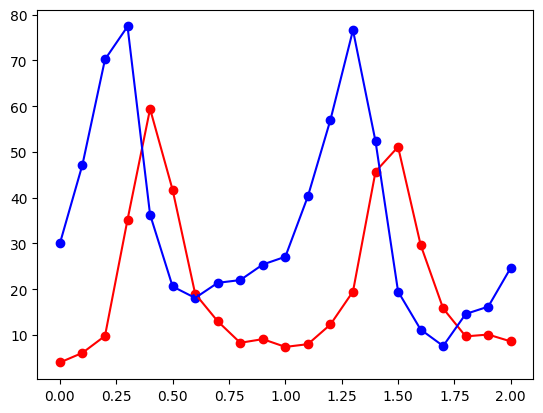

In [418]:
lynx = torch.tensor([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4, 8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare = torch.tensor([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
Y = torch.cat((torch.arange(len(lynx))[:, None], lynx[:, None], hare[:, None]), -1)

plt.plot(Y[:, 0]*.1, Y[:, 1], c='red')
plt.plot(Y[:, 0]*.1, Y[:, 2], c='blue')
plt.scatter(Y[:, 0]*.1, Y[:, 1], c='red')
plt.scatter(Y[:, 0]*.1, Y[:, 2], c='blue')
plt.show()

In [430]:
class GLV(nn.Module):
    @attrmethod
    def __init__(self, optim='adam', *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.log_ = []
        self.g_log_ = []
        self.i_log_ = []

    def _build(self, x0, learning_rate=1e-3):
        # self.growth_rates_ = nn.Parameter(.04*torch.rand(c := len(x0), requires_grad=True) - .02)
        self.growth_rates_ = nn.Parameter(torch.zeros(c := len(x0), requires_grad=True))
        # self.growth_rates_ = torch.tensor((1.3, -1.8))
        # self.interactions_ = nn.Parameter(.04*torch.rand(c := len(x0), c, requires_grad=True) - .02)
        self.interactions_ = nn.Parameter(torch.zeros(c, c, requires_grad=True))
        # self.interactions_ = torch.tensor(((0., -.9), (.8, 0.)))
        # self.m = MLP(c := len(x0), 2*c, 4*c, 2*c, c, act_layer='relu')
        self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

        return self

    def step(self, loss):
        loss.backward()
        self._optim.step()
        self._optim.zero_grad()

        self.g_log_.append(self.growth_rates_.clone().detach())
        self.i_log_.append(self.interactions_.clone().detach())

        return self

    def model(self, x, growth_rates=None, interactions=None):
        if growth_rates is None:
            growth_rates = self.growth_rates_

        if interactions is None:
            interactions = self.interactions_

        dx = x*(growth_rates + interactions@x)
        # dx = self.m(x)

        return dx

    def forward(self, x, y=None, dt=.1, *args, **kwargs):
        # k1 = self.model(x, *args, **kwargs)
        # k2 = self.model(x + k1*dt/2, *args, **kwargs)
        # k3 = self.model(x + k2*dt/2, *args, **kwargs)
        # k4 = self.model(x + k3*dt, *args, **kwargs)
        # x_ = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6
        x_ = x + self.model(x, *args, **kwargs)*dt

        if y is not None:
            loss = (x_ - y).square().sum()
            
            return x_, loss
        return x_

    @buildmethod
    def fit(self, Y, x0, dt=1., n_epochs=1000, n_steps=100, learning_rate=1e-3, verbosity=1):
        for j in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            x, idx, loss = x0.clone(), -1, 0

            # if j in (300, 900):
            #     learning_rate = 3e-3
            #     self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

            # if j == 1000:
            #     learning_rate = 5e-3
            #     self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

            # if j == 600:
            #     learning_rate = 1e-3
            #     self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

            for i in range(n_steps):
                if i in Y[1:, 0]:
                    x, l = self(x, Y[idx := idx + 1, 1:])
                    loss += l
                else:
                    x = self(x)

            self.step(loss)
            self.log_.append(loss.item())

        return self

100%|██████████| 1000/1000 [00:02<00:00, 482.36it/s]


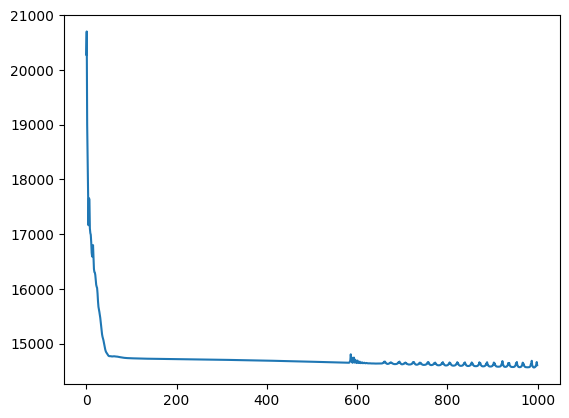

In [431]:
model = GLV()
model.fit(Y, Y[0, 1:])
plt.plot(range(len(model.log_)), model.log_)
plt.show()

In [388]:
steps.shape

(300,)

In [419]:
Y[:, 0] *= 100/20

In [425]:
Y[:, 0]

tensor([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
         60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

100%|██████████| 99/99 [00:00<00:00, 17899.65it/s]


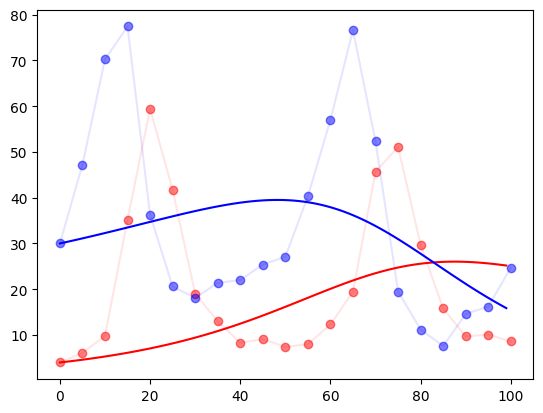

In [433]:
(X_ := torch.zeros((100, 2)))[0] = Y[0, 1:]
steps = np.arange(len(X_))

for i in tqdm(range(1, len(X_))):
    X_[i] = model(X_[i - 1])

plt.plot(Y[:, 0], Y[:, 1], c='red', alpha=.1)
plt.plot(Y[:, 0], Y[:, 2], c='blue', alpha=.1)
plt.scatter(Y[:, 0], Y[:, 1], c='red', alpha=.5)
plt.scatter(Y[:, 0], Y[:, 2], c='blue', alpha=.5)
plt.plot(steps, X_[:, 0].detach(), c='red')
plt.plot(steps, X_[:, 1].detach(), c='blue')
plt.show()

In [ ]:
class UDE(nn.Module):
    @attrmethod
    def __init__(self, bias=True, norm_layer='batch', act_layer='relu', optim='adam', *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _build(self, x0, learning_rate=1e-1):
        channels = (in_channels := len(x0), 2*in_channels, in_channels)
        self.model_ = MLP(*channels, bias=self.bias, norm_layer=self.norm_layer, act_layer=self.act_layer)
        self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

        return self

    @buildmethod
    def fit(self, x0, n_steps=300, n_epochs=1000, learning_rate=1e-1, verbosity=1):
        for i in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            pass

In [23]:
data

tensor([[0.4425, 4.6281],
        [3.0801, 6.6994],
        [8.8519, 1.2231],
        [5.9141, 0.1691],
        [3.3643, 0.0719],
        [1.8821, 0.0642]])